# RLLBC Bonus Point Assignment II Part B
<div style="text-align: right;font-size: 0.8em">Document Version 1.0.0, released 2022-06-24</div>
For task instructions, refer to the assignment PDF.

* The parts of the code you are to implement are indicated via `# TODO` comments.
* You can use the `# Test code` cells to verify your implementation. However note that these are not the unit tests used for grading.
* Some cells create export file in the `solution/` folder. _Include whole `solution/` folder in your submission_.
* DO NOT CLEAR THE OUTPUT of the notebook you are submitting!

In [1]:
# General imports
from pathlib import Path
from copy import deepcopy
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gym
from tqdm.auto import tqdm
# Create solution folder
Path("solution/").mkdir(exist_ok=True)

/home/mattis/miniconda3/envs/rllbc_bpa2/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/home/mattis/miniconda3/envs/rllbc_bpa2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Question B1 - Deep Q-Networks
### a) Implement Replay Buffer

In [2]:
class ReplayBuffer(object):
    def __init__(self, mem_size, state_shape):
        """Initialization of the replay buffer.
        
        The memories have the following data types:
            states: float32
            next_states: float32
            actions: int64
            rewards: float32
            is_terminal: bool

        Args:
            mem_size: Capacity of this buffer
            state_shape: Shape of state and next_state
        """
        self.mem_size = mem_size  # Capacity of the buffer
        self.mem_cntr = 0         # Number of added elements
        self.state_memory = np.zeros((self.mem_size, *state_shape), dtype=np.float32)
        self.next_state_memory = np.zeros((self.mem_size, *state_shape), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)
    
    def is_filled(self):
        """Check if the memory is filled."""
        return buffer.mem_cntr >= buffer.mem_size

    def add(self, state, action, reward, next_state, is_terminal):
        """Add one transition to the buffer.

        Replaces the oldest transition in memory.
        """
        # TODO
        idx=self.mem_cntr % self.mem_size
        self.state_memory[idx]=state
        self.action_memory[idx]=action
        self.reward_memory [idx]=reward
        self.terminal_memory[idx]=is_terminal
        self.next_state_memory[idx]=next_state
        self.mem_cntr+=1


    def sample_batch(self, batch_size):
        """Sample one batch from the memory."""
        # TODO
        states=[]
        actions=[]
        rewards=[]
        next_states=[]
        is_terminal=[]
        indices = np.random.choice(self.mem_size, batch_size, replace=False)
        for idx in indices:
            states.append(self.state_memory[idx])
            actions.append(self.action_memory[idx])
            rewards.append(self.reward_memory[idx])
            next_states.append(self.next_state_memory[idx])
            is_terminal.append(self.terminal_memory[idx])
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(is_terminal)

In [3]:
# Test code
_buffer = ReplayBuffer(10, (5, ))
assert _buffer.mem_size == 10
assert _buffer.mem_cntr == 0
for i in range(10):  # Fill test values
    _buffer.add(np.arange(5) + i, 5 + i, 6 + i, 7 + np.arange(5) + i, (12 + i) % 2 == 0)
assert _buffer.mem_size == 10
assert _buffer.mem_cntr == 10, "Wrong mem_cntr"

_is = set()
for s, a, r, s_, t in zip(*_buffer.sample_batch(5)):
    i = s[0]
    assert 0 <= i < 10, "Wrong states"
    _is.add(i)
    np.testing.assert_array_equal(s, np.arange(5) + i, err_msg="Wrong states")
    np.testing.assert_equal(a, 5 + i, err_msg="Wrong actions")
    np.testing.assert_equal(r, 6 + i, err_msg="Wrong rewards")
    np.testing.assert_array_equal(s_, 7 + np.arange(5) + i, err_msg="Wrong next states")
    np.testing.assert_equal(t, (12 + i) % 2 == 0, err_msg="Wrong terminals")
assert len(_is) == 5, "Duplicate transitions"
"ok"

/tmp/ipykernel_5578/3445573640.py:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)


'ok'

### b) Fill replay buffer

In [4]:
env = gym.make('CartPole-v1')

# Initialize replay buffer
buffer = ReplayBuffer(mem_size=25000, state_shape=env.observation_space.shape)
while not(buffer.is_filled()):
    observation = env.reset()
    action=env.action_space.sample()
    newObservation, reward, done, info = env.step(action)
    isterminal= (done and env._elapsed_steps < 500)
    buffer.add(observation,action,reward,newObservation,isterminal)
# ********************
# TODO Sample transitions from environment and add to buffer


/home/mattis/miniconda3/envs/rllbc_bpa2/lib/python3.9/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/mattis/miniconda3/envs/rllbc_bpa2/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/tmp/ipykernel_5578/3445573640.py:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: 

In [5]:
# Test code
assert buffer.is_filled(), f"Buffer not filled, only {buffer.mem_cntr}/{buffer.mem_size} transitions in memory"
"ok"

'ok'

## Question B2 - Deep Q-Networks
### a) Define Q-Network

In [6]:
import torch
from torch import nn
from torch import max
import torch.nn.functional as F
from torch.autograd import Variable

class DeepQNetwork(nn.Module):
    def __init__(self):
        super(DeepQNetwork, self).__init__()
        # TODO Create layers
        # original
        self.model = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            #nn.Dropout(),
            nn.Linear(32, env.action_space.n)
            #nn.ReLU()
        )
        



    def forward(self, state):
        #x = self.layer1(state)
        #x = self.dropout(torch.sigmoid(self.layer2(x)))
        #action_value = F.relu(self.layer3(x))
        action_value = self.model(state)
                
        return action_value

In [7]:
# Test code
_test_output = DeepQNetwork()(torch.FloatTensor([[1, 2, 3, 4]]))
assert _test_output.shape == (1, 2), f"Expected output shape (1, 2), got {_test_output.shape}"
"ok"

'ok'

### b) $\epsilon$-Greedy

In [8]:
def epsilon_greedy(state, q_network, epsilon=0.05):
    """Perform epsilon-greedy action sampling.

    Args:
        state: numpy ndarray, current state
        q_network: torch module

    Returns:
        action: one action
    """
    # TODO Epsilon-greedy action sampling
    if np.random.rand() <= epsilon:
        action = env.action_space.sample()
        return action
    state = torch.from_numpy(state).float().unsqueeze(0)
    actions = q_network(state)
    action = torch.argmax(actions).item()
    return int(action)


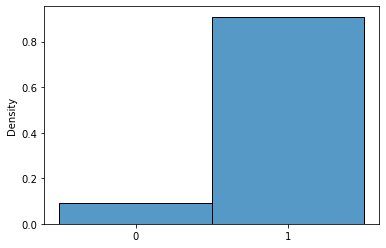

In [9]:
# Test Code
class DummyModule(nn.Module):
    def forward(self, state):
        return torch.FloatTensor([1, 2])  # Constant output


# Sample 1000 actions
_actions = [epsilon_greedy(np.array([1, 2, 3, 4]), DummyModule(), epsilon=0.2) for _ in range(1000)]

sns.histplot(_actions, discrete=True, stat="density")
plt.xticks([0, 1])
plt.show()

_zeros = 1000 - sum(_actions)
# Note: This is a stochastic test. It produces a false error in 1% of the cases
assert 75 < _zeros < 125, f"Frequency of action 0 ({_zeros}) is outside the 99% confidence interval [76, 124]"

### c) Loss Function

In [10]:
mse = nn.MSELoss()

def compute_loss(q_network, target_network, states, actions, rewards, next_states, is_terminal, gamma=0.99):
    # TODO Implement loss function
    qvals = q_network(states).gather(1, actions)
    anext=  q_network(next_states).argmax(dim=1).unsqueeze(-1)
    qnext = target_network(next_states).gather(1, anext)
    target=gamma * (1 - is_terminal.bool().int()) * qnext.reshape(1, -1)
    expected_q_value=rewards+target.reshape(-1,1)
    loss = mse(qvals, expected_q_value)
    return loss
  


### d) Training

Mean training reward 500.00:  82%|████████▏ | 1643/2000 [04:14<00:55,  6.47it/s]


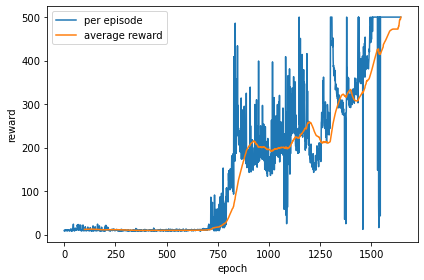

In [11]:
# Hyperparameters
epsilon = 0.05  # For epsilon greedy action sampling
batch_size = 256
NETWORK_UPDATE_FREQUENCY = 4
NETWORK_SYNC_FREQUENCY = 2000
gamma = 0.999
episodes = 2000# 10000
replay_buffer_size = 10000 #TODO


q_network = DeepQNetwork()
target_network = deepcopy(q_network)
optimizer = torch.optim.Adam(q_network.parameters(), lr=1e-3)
mse = nn.MSELoss()

step_count = 0
total_rewards = []
with tqdm(range(episodes)) as pbar:
    for _ in pbar:
        state, done = env.reset(), False
        rewards = []

        while not done:
            # Take a step
            action = epsilon_greedy(state, q_network, epsilon=epsilon)
            next_state, reward, done, _ = env.step(action)

            # Bookkeeping
            rewards.append(reward)
            buffer.add(state=state, action=action, reward=reward, next_state=next_state, is_terminal=done and env._elapsed_steps < 500)
            state = next_state

            step_count += 1

            # Update network every NETWORK_UPDATE_FREQUENCY steps
            if step_count % NETWORK_UPDATE_FREQUENCY == 0:
                # Sample batch of transitions
                state_batch, action_batch, reward_batch, next_state_batch, terminal_batch = buffer.sample_batch(batch_size=batch_size)
                state_batch = torch.FloatTensor(state_batch)
                next_state_batch = torch.FloatTensor(next_state_batch)
                action_batch = torch.LongTensor(action_batch).reshape(-1, 1)
                reward_batch = torch.FloatTensor(reward_batch).reshape(-1, 1)
                terminal_batch = torch.BoolTensor(terminal_batch)

                # Compute loss
                loss = compute_loss(q_network, target_network, state_batch, action_batch, reward_batch, next_state_batch, terminal_batch, gamma)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
           
            # Sync networks every NETWORK_SYNC_FREQUENCY steps
            if step_count % NETWORK_SYNC_FREQUENCY == 0:
                # ********************
                # TODO Synchronize networks
                target_network.load_state_dict(q_network.state_dict())



                # ********************

        total_rewards.append(sum(rewards))

         # Print statistics
        pbar.set_description(f"Mean training reward {np.mean(total_rewards[-100:]):.02f}")
        if np.mean(total_rewards[-100:]) == 500:
            break # Stop training

# Save model
with open("solution/b2d.pt", "wb") as f:
    torch.save(q_network, f)

# Plot training
plt.plot(total_rewards, label="per episode")
plt.plot(pd.DataFrame(total_rewards).rolling(100).mean(), label="average reward")
plt.xlabel("epoch")
plt.ylabel("reward")
plt.legend()
plt.tight_layout()
plt.savefig("solution/b2d.png")

In [12]:
# Test code
policy = q_network
policy.eval()  # Switch to evaluation mode


def _rollout(seed):
    env.reset(seed=seed)
    state, done = env.reset(), False
    while not done:
        probs = policy(torch.tensor(state).float().reshape((1, -1)))[0]
        action = np.argmax(probs.detach().numpy())  # Greedy action
        state, reward, done, _ = env.step(action)
    return env._elapsed_steps


_avg_reward = np.mean([_rollout(seed=i) for i in tqdm(range(100), desc="Validating")])
assert _avg_reward >= 487.5, f"Average reward below 487.5, got {_avg_reward}"
f"ok (Average reward {_avg_reward:0.2f})"

Validating: 100%|█████████████████████████████| 100/100 [00:08<00:00, 11.57it/s]


'ok (Average reward 500.00)'